# 3D Image Classification from Jacobian Maps Derived from MRI Scans

**Author:** [Andjela Dimitrijevic](https://twitter.com/AndjelaaaaDimi)<br>
**Date created:** 2023/09/23<br>
**Last modified:** 2023/10/24<br>
**Description:** Train a 3D convolutional neural network to predict if Jacobian maps are from intra or inter-subject pairs of MRI scans

## Source
This code has been adapted from this very well explained [github project](https://github.com/hasibzunair/3D-image-classification-tutorial) by Hasib Zunair where more resources can be found concerning th euse of 3D CNNs in medical imaging.

## Setup

In [1]:
# tf2 environment
import os
import glob
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. Log Jacobians are obtained using ANTs SyN method for both inter and intra pairs. These have values between -1 and 1 because of the log operation. Values smaller than 0 indicate expanding, larger than 0, contracting regions and no volume change is represented by a voxel value of 0.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We keep the values between -1 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [2]:

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # No normalization want to keep values from -1 to 1, only converts to float32
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the MRI scans from the class directories.

In [3]:
# Folder "intra" consists of MRI scans from intra-registration and "inter" from inter-registration pairs.

path = '/home/andjela/Documents/intra-inter-ddfs'
intra_scan_paths = glob.glob(f"{path}/intra/**/logJacobian.nii.gz", recursive=True)

inter_scan_paths = glob.glob(f"{path}/inter/**/logJacobian.nii.gz", recursive=True)

print("MRI scans with intra log Jacobian: " + str(len(intra_scan_paths)))
print("MRI scans with inter log Jacobian: " + str(len(inter_scan_paths)))


MRI scans with intra log Jacobian: 434
MRI scans with inter log Jacobian: 421


In [4]:
def read_tsv_and_create_dict(file_path):
    participant_mapping = {}
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Check if the participant_id is already in the mapping, if not, assign it a unique identifier
            if participant_id not in participant_mapping:
                unique_id = len(participant_mapping)
                participant_mapping[participant_id] = {'id': unique_id, 'scan_ids': []}
            
            # Append the scan_id to the participant's list
            participant_mapping[participant_id]['scan_ids'].append(scan_id)
    
    return participant_mapping

In [5]:
# Specify the path to your TSV file
file_path = '/home/andjela/Documents/intra-inter-ddfs/src/participants.tsv'

# Call the function to create the dictionary for all 64 patients
participant_mapping = read_tsv_and_create_dict(file_path)

# Print the dictionary
# for participant_id, info in participant_mapping.items():
#     print(f"Participant ID: {participant_id} (Mapped to {info['id']})")
#     print(f"Associated Scan IDs: {', '.join(info['scan_ids'])}")
#     print()


In [6]:
def find_scan_ids(name):
    #Outputs patient number, moving and fixed image scanID as strings for further analysis
    #Possible folder name pairs are below with each string differing in length
    # name = 'CL_Dev_004_CL_Dev_008'
    # name1 = 'CL_Dev_004_PS15_048'
    # name2 = 'PS15_048_CL_Dev_004'
    # name3 = 'PS15_048_PS17_017'
    # name4 = 'PS16_058_PS1183-10-1'

    #idx contains a list of strings of a given name
    idx = [s for s in name.split("_")]
    

    if len(idx) == 6:
        
        mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
        fix = f'{idx[3]}_{idx[4]}_{idx[5]}'
        return(mov, fix)

    elif len(idx) == 5:
        if 'CL' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
            fix = f'{idx[3]}_{idx[4]}'
            
            return(mov, fix)
        elif 'PS' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}'
            fix = f'{idx[2]}_{idx[3]}_{idx[4]}'
            
            return(mov, fix)

    elif len(idx) == 4:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}_{idx[3]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' not in idx[2]:
        mov = f'{idx[0]}'
        fix = f'{idx[1]}_{idx[2]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' in idx[2]:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}'
        return(mov, fix)

    else:
        print('Not a corresponding folder name', name)

In [7]:
# Initialize a list to store pairs of participant IDs
all_participant_ids = []

all_paths = np.concatenate((intra_scan_paths, inter_scan_paths), axis=0)

# Iterate over the intra and inter _scan_paths
for path in all_paths:
    # Extract the scan_id from the path
    scan_ids = path.split('/')[-2]
    scan_id_1, scan_id_2 = find_scan_ids(scan_ids)
    
    # Find participant_ids for scan_id_1 and scan_id_2
    participant_id_1 = None
    participant_id_2 = None

    for participant_id, info in participant_mapping.items():
        if scan_id_1 in info['scan_ids']:
            participant_id_1 = participant_id
        if scan_id_2 in info['scan_ids']:
            participant_id_2 = participant_id

    # print(participant_id_1, participant_id_2)

    # Create pairs
    if participant_id_1 is None and participant_id_2 is None:
        print(scan_id_1, scan_id_2)
    if participant_id_1 is not None and participant_id_2 is not None:
        all_participant_ids.append((participant_id_1, participant_id_2))

print(all_participant_ids)
print('Number of pairs in total (both intra and inter):', len(all_participant_ids))

[('10077', '10077'), ('10087', '10087'), ('10010', '10010'), ('10010', '10010'), ('10056', '10056'), ('10022', '10022'), ('10009', '10009'), ('10137', '10137'), ('10010', '10010'), ('10032', '10032'), ('10087', '10087'), ('10110', '10110'), ('10025', '10025'), ('10117', '10117'), ('10117', '10117'), ('10061', '10061'), ('10109', '10109'), ('10065', '10065'), ('10044', '10044'), ('10094', '10094'), ('10007', '10007'), ('10021', '10021'), ('10109', '10109'), ('10117', '10117'), ('10137', '10137'), ('10065', '10065'), ('10054', '10054'), ('10096', '10096'), ('10021', '10021'), ('10077', '10077'), ('10137', '10137'), ('10054', '10054'), ('10096', '10096'), ('10117', '10117'), ('10064', '10064'), ('10096', '10096'), ('10090', '10090'), ('10104', '10104'), ('10042', '10042'), ('10089', '10089'), ('10059', '10059'), ('10049', '10049'), ('10136', '10136'), ('10010', '10010'), ('10025', '10025'), ('10047', '10047'), ('10136', '10136'), ('10021', '10021'), ('10046', '10046'), ('10117', '10117'),

In [98]:
# To cut off parts of the inter pairs in order to be able to have the right ratio split for train,val and test
part_participant_ids = all_participant_ids[:500]
print('New number of pairs in total (both intra and inter):', len(part_participant_ids))

New number of pairs in total (both intra and inter): 500


In [8]:
import random 

def shuffle_keys(dictionary, random_seed):
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Extract the keys from the dictionary
    keys = list(dictionary.keys())
    
    # Shuffle the keys
    random.shuffle(keys)
    
    # Create a new dictionary with shuffled keys
    shuffled_dict = {key: dictionary[key] for key in keys}
    
    return shuffled_dict

In [11]:
import random

def custom_split_indices(data, train_ratio, val_ratio, test_ratio, random_state=None):


    # Create dictionaries to track subjects by participant_id
    indices_by_subject = {}
    
    # Initialize lists for train, validation, and test indices
    train_indices, val_indices, test_indices = set(), set(), set()
    
    
    # Iterate through the data and group indices by participant_id (subject_number)
    for i, (participant_id_1, participant_id_2) in enumerate(data):
        if participant_id_1 not in indices_by_subject:
            indices_by_subject[participant_id_1] = []
        
        if participant_id_2 not in indices_by_subject:
            indices_by_subject[participant_id_2] = []
            
        
        indices_by_subject[participant_id_1].append(i)
        if participant_id_2 != participant_id_1:
            indices_by_subject[participant_id_2].append(i)

    # Shuffle all subject keys in the created dictionnary mapping indices
    if random_state is not None:
        shuffled_indices_by_subject = shuffle_keys(indices_by_subject, random_state)
    wanted_ratios = [train_ratio, val_ratio, test_ratio]
    # Iterate through the subjects, shuffling the order of subjects for each participant_id (subject)
    for subject, indices in shuffled_indices_by_subject.items():

        # Cut-off to keep only 14 fist indices to obtain the correct ratio for each set to obatin non overlapping subjects per set
        # indices = indices[:14]

        overlapping_train = bool(train_indices.intersection(set(indices)))
        overlapping_val = bool(val_indices.intersection(set(indices)))
        overlapping_test = bool(test_indices.intersection(set(indices)))

        if overlapping_train + overlapping_val + overlapping_test >=2:
            continue
        
        if overlapping_train:
            train_indices.update(set(indices))
            continue
        if overlapping_val:
            val_indices.update(set(indices))
            continue
        if overlapping_test:
            test_indices.update(set(indices))
            continue 
        # Calculate current ratios per set
        if len(train_indices)+len(val_indices)+len(test_indices) == 0:
            train_indices.update(set(indices))
            continue

        current_train_ratio = len(train_indices)/(len(train_indices)+len(val_indices)+len(test_indices))    
        current_val_ratio = len(val_indices)/(len(train_indices)+len(val_indices)+len(test_indices))   
        current_test_ratio = len(test_indices)/(len(train_indices)+len(val_indices)+len(test_indices))

        max_idx = np.argmax(np.array(wanted_ratios)-np.array([current_train_ratio, current_val_ratio, current_test_ratio])/np.array(wanted_ratios)) 
        if max_idx == 0:
            train_indices.update(set(indices))
        elif max_idx == 1:
            val_indices.update(set(indices))
        else:
            test_indices.update(set(indices))
    
    return train_indices, val_indices, test_indices, indices_by_subject

# Example usage:

# Train 6
# train_indices, val_indices, test_indices, indices_by_subject = custom_split_indices(all_participant_ids, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_state=42)
# Train 7
train_indices, val_indices, test_indices, indices_by_subject = custom_split_indices(all_participant_ids, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_state=42)


# Calculate the total length of all indices
total_length = len(train_indices) + len(val_indices) + len(test_indices)
print('Total number of indices:', total_length)

# Calculate the percentages
train_percentage = (len(train_indices) / total_length) * 100
val_percentage = (len(val_indices) / total_length) * 100
test_percentage = (len(test_indices) / total_length) * 100

print("Train Indices:")
print(len(train_indices))
print(f"Train Percentage: {train_percentage:.2f}%")

print("Validation Indices:")
print(len(val_indices))
print(f"Validation Percentage: {val_percentage:.2f}%")

print("Test Indices:")
print(len(test_indices))
print(f"Test Percentage: {test_percentage:.2f}%")

print(f"Total Length: {total_length}")
print(f"Total Percentage (should be 100%): {train_percentage + val_percentage + test_percentage:.2f}%")



Total number of indices: 508
Train Indices:
351
Train Percentage: 69.09%
Validation Indices:
124
Validation Percentage: 24.41%
Test Indices:
33
Test Percentage: 6.50%
Total Length: 508
Total Percentage (should be 100%): 100.00%


In [12]:
train_ratio=0.7
val_ratio=0.2
test_ratio=0.1
wanted_ratios = [train_ratio, val_ratio, test_ratio]
lowest_norm = np.linalg.norm(np.array(wanted_ratios))
selected_train_indices = []
selected_val_indices = []
selected_test_indices = []
selected_random_state = []
for i in range(2000):
    train_indices, val_indices, test_indices, indices_by_subject = custom_split_indices(all_participant_ids, train_ratio, val_ratio, test_ratio, random_state=i)
    current_train_ratio = len(train_indices)/(len(train_indices)+len(val_indices)+len(test_indices))    
    current_val_ratio = len(val_indices)/(len(train_indices)+len(val_indices)+len(test_indices))   
    current_test_ratio = len(test_indices)/(len(train_indices)+len(val_indices)+len(test_indices))

    diff_norm = np.linalg.norm(np.array(wanted_ratios) - np.array([current_train_ratio, current_val_ratio, current_test_ratio]))
    if diff_norm < lowest_norm:
        lowest_norm = diff_norm
        selected_train_indices = train_indices
        selected_val_indices = val_indices
        selected_test_indices = test_indices
        selected_random_state = i
    
# Calculate the total length of all indices
total_length = len(selected_train_indices) + len(selected_val_indices) + len(selected_test_indices)
print('Total number of indices:', total_length)

# Calculate the percentages
train_percentage = (len(selected_train_indices) / total_length) * 100
val_percentage = (len(selected_val_indices) / total_length) * 100
test_percentage = (len(selected_test_indices) / total_length) * 100

print("Train Indices:")
print(len(selected_train_indices))
print(f"Train Percentage: {train_percentage:.2f}%")

print("Validation Indices:")
print(len(selected_val_indices))
print(f"Validation Percentage: {val_percentage:.2f}%")

print("Test Indices:")
print(len(selected_test_indices))
print(f"Test Percentage: {test_percentage:.2f}%")

print(f"Total Length: {total_length}")
print(f"Total Percentage (should be 100%): {train_percentage + val_percentage + test_percentage:.2f}%")

print('The chosen random_state should be:', selected_random_state)

Total number of indices: 485
Train Indices:
340
Train Percentage: 70.10%
Validation Indices:
94
Validation Percentage: 19.38%
Test Indices:
51
Test Percentage: 10.52%
Total Length: 485
Total Percentage (should be 100%): 100.00%
The chosen random_state should be: 1130


In [9]:
import random

def custom_split_indices(data, ratio, nbr_sets, random_state=None):


    # Create dictionaries to track subjects by participant_id
    indices_by_subject = {}
    
    # Define a list to hold the sets
    all_sets = [set() for _ in range(nbr_sets)]
    
    
    # Iterate through the data and group indices by participant_id (subject_number)
    for i, (participant_id_1, participant_id_2) in enumerate(data):
        if participant_id_1 not in indices_by_subject:
            indices_by_subject[participant_id_1] = []
        
        if participant_id_2 not in indices_by_subject:
            indices_by_subject[participant_id_2] = []
            
        
        indices_by_subject[participant_id_1].append(i)
        if participant_id_2 != participant_id_1:
            indices_by_subject[participant_id_2].append(i)

    # Shuffle all subject keys in the created dictionnary mapping indices
    if random_state is not None:
        shuffled_indices_by_subject = shuffle_keys(indices_by_subject, random_state)

    wanted_ratios = [ratio] * nbr_sets
    iteration = 0
    # Iterate through the subjects, shuffling the order of subjects for each participant_id (subject)
    for subject, indices in shuffled_indices_by_subject.items():
        # print(f"Subject: {subject}")
        iteration += 1  # Increment iteration count
        subject_overlapping = []  # Overlapping for each subject
        for a_set in all_sets:
            overlapping = bool(a_set.intersection(set(indices)))
            subject_overlapping.append(overlapping)

        # Skip that pair if there's overlapping with at least 2 sets, if there is only 1, then update indices where it overlaps, else if there are no
        # overlaps, choose the less populated set to be updated
        if sum(subject_overlapping) == 1:
            for i, a_set in enumerate(all_sets):
                if subject_overlapping[i]:
                    a_set.update(set(indices))
                    break
            continue
        elif sum(subject_overlapping) >= 2:
            continue

        else:
        
            total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
            if total_indices_all_sets == 0:
                all_sets[0].update(set(indices))
                continue

            # Calculate current ratios 
            current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

            # Find where there is the bigger difference between the wanted ratios and the current ratios
            max_idx = np.argmax((np.array(wanted_ratios)-np.array(current_ratios))/np.array(wanted_ratios)) 
            # Update the set based on max_idx
            if max_idx < len(all_sets):
                # Update the set at the specific index indicated by max_idx
                all_sets[max_idx].update(set(indices))
            else:
                print("max_idx is out of range for all_sets")
        # Verify when 2 sets have overlapping indices
        flag = False
        for i in range(len(all_sets)):
            for j in range(i + 1, len(all_sets)):
                if all_sets[i].intersection(all_sets[j]):
                    overlapping = True
                    print(f"Sets {i} and {j} have overlapping indices.")
                    print(subject)
                    flag = True
                    break
                if flag:
                    break
        if flag:
            print(f"Condition met at iteration {iteration}")  # Print the iteration when the condition is met
            break
    
    return all_sets, indices_by_subject

# Example usage:

all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=42)


# Calculate the total length of all indices in all_sets
total_indices = sum(len(a_set) for a_set in all_sets)

print("Total number of indices in all sets:", total_indices)

# Calculate the percentage of indices in each set
for i, a_set in enumerate(all_sets):
    print(len(a_set))
    set_length = len(a_set)
    percentage = (set_length / total_indices) * 100
    print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

overlapping = False

for i in range(len(all_sets)):
    for j in range(i + 1, len(all_sets)):
        if all_sets[i].intersection(all_sets[j]):
            overlapping = True
            print(f"Sets {i} and {j} have overlapping indices.")

if not overlapping:
    print("No sets have overlapping indices.")




Total number of indices in all sets: 351
15
Set 1 has 15 indices, which is 4.27% of the total.
124
Set 2 has 124 indices, which is 35.33% of the total.
19
Set 3 has 19 indices, which is 5.41% of the total.
33
Set 4 has 33 indices, which is 9.40% of the total.
12
Set 5 has 12 indices, which is 3.42% of the total.
53
Set 6 has 53 indices, which is 15.10% of the total.
20
Set 7 has 20 indices, which is 5.70% of the total.
35
Set 8 has 35 indices, which is 9.97% of the total.
13
Set 9 has 13 indices, which is 3.70% of the total.
27
Set 10 has 27 indices, which is 7.69% of the total.
No sets have overlapping indices.


In [10]:
nbr_sets = 10
ratio = 0.1
wanted_ratios =  [ratio] * nbr_sets
lowest_norm = np.linalg.norm(np.array(wanted_ratios))
selected_indices = [[] for _ in range(nbr_sets)]
for i in range(5000):
    all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=i)
    total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
    current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

    diff_norm = np.linalg.norm(np.array(wanted_ratios) - np.array(current_ratios))
    if diff_norm < lowest_norm:
        lowest_norm = diff_norm
        for x, a_set in enumerate(all_sets):
            selected_indices[x] = a_set
        selected_random_state = i

all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=selected_random_state)

# Calculate the total length of all indices in all_sets
total_indices = sum(len(a_set) for a_set in all_sets)

print("Total number of indices in all sets:", total_indices)

# Calculate the percentage of indices in each set
for i, a_set in enumerate(all_sets):
    set_length = len(a_set)
    percentage = (set_length / total_indices) * 100
    print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

print('The chosen random_state should be:', selected_random_state)

Total number of indices in all sets: 279
Set 1 has 30 indices, which is 10.75% of the total.
Set 2 has 18 indices, which is 6.45% of the total.
Set 3 has 26 indices, which is 9.32% of the total.
Set 4 has 33 indices, which is 11.83% of the total.
Set 5 has 21 indices, which is 7.53% of the total.
Set 6 has 26 indices, which is 9.32% of the total.
Set 7 has 27 indices, which is 9.68% of the total.
Set 8 has 34 indices, which is 12.19% of the total.
Set 9 has 35 indices, which is 12.54% of the total.
Set 10 has 29 indices, which is 10.39% of the total.
The chosen random_state should be: 2641


In [11]:
data_2 = np.array(selected_indices)
for i, a_set in enumerate(data_2):
    num_elements = len(a_set)
    print(f"Number of elements in set {i}: {num_elements}")

Number of elements in set 0: 30
Number of elements in set 1: 18
Number of elements in set 2: 26
Number of elements in set 3: 33
Number of elements in set 4: 21
Number of elements in set 5: 26
Number of elements in set 6: 27
Number of elements in set 7: 34
Number of elements in set 8: 35
Number of elements in set 9: 29


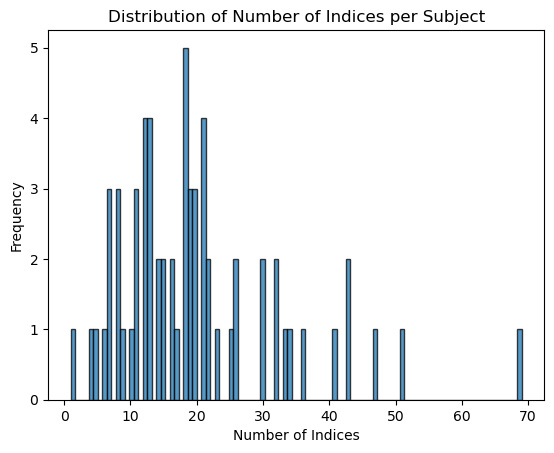

In [12]:
import matplotlib.pyplot as plt
# Count the number of indices per subject
num_indices_per_subject = [len(indices) for indices in indices_by_subject.values()]

# Create a histogram plot
plt.hist(num_indices_per_subject, bins=100, alpha=0.75, edgecolor='k')
plt.title("Distribution of Number of Indices per Subject")
plt.xlabel("Number of Indices")
plt.ylabel("Frequency")

# Show the plot
plt.show()

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [13]:
train_indices_list = []
val_indices_list = []
test_indices_list = []

for i in range(10):
    test_indices = list(all_sets[i])  # Set the test set

    # Determine the start of the validation indices based on the test index
    val_start = i * 2 + 1

    val_set_1 = list(all_sets[val_start % 10])  # First validation set
    val_set_2 = list(all_sets[(val_start + 1) % 10])  # Second validation set

    # Train indices are the rest of the sets not used for test and validation
    train_indices = []
    for j in range(10):
        if j not in [i, val_start % 10, (val_start + 1) % 10]:
            train_indices.extend(list(all_sets[j]))

    train_indices_list.append(train_indices)
    val_indices_list.append(val_set_1 + val_set_2)
    test_indices_list.append(test_indices)

    # Use the sets as needed (train, validation, test)
    # For example:
    print(f"Iteration {i + 1}:")
    print("Train sets:", train_indices)
    print("Validation sets:", val_set_1 + val_set_2)
    print("Test set:", test_indices)
    print()



Iteration 1:
Train sets: [641, 772, 773, 774, 709, 456, 714, 651, 78, 145, 723, 854, 534, 280, 26, 794, 347, 475, 350, 31, 288, 416, 744, 554, 111, 306, 372, 246, 311, 504, 121, 122, 702, 384, 66, 387, 454, 265, 585, 213, 536, 665, 734, 738, 298, 682, 237, 430, 687, 622, 433, 438, 378, 571, 707, 838, 519, 392, 843, 652, 588, 532, 725, 726, 791, 474, 540, 285, 670, 480, 34, 420, 617, 362, 623, 690, 691, 505, 699, 828, 453, 713, 650, 524, 460, 527, 847, 401, 591, 787, 471, 476, 800, 608, 164, 804, 614, 39, 484, 683, 625, 563, 692, 501, 503, 56, 444, 512, 581, 327, 458, 844, 721, 340, 85, 788, 663, 537, 282, 602, 541, 671, 351, 482, 229, 742, 743, 679, 41, 105, 491, 108, 302, 751, 560, 756, 821, 696, 633, 317, 446, 577, 642, 706, 580, 644, 777, 267, 76, 781, 16, 144, 851, 469, 662, 22, 664, 792, 730, 279, 732, 728, 731, 545, 550, 615, 42, 492, 109, 46, 367, 307, 437, 57, 250, 381, 640, 65, 129, 775, 711, 139, 141, 782, 784, 465, 789, 797, 607, 546, 163, 38, 426, 811, 171, 370, 371, 628, 1

In [14]:
sum = 0 
list_total = []
for i in range(len(test_indices_list)):
    elements = test_indices_list[i]
    size = len(set(test_indices_list[i])) 
    print(size)
    sum += size
    list_total.extend(elements)
print('total number of pairs:', sum)
print(len(np.unique(list_total)))



30
18
26
33
21
26
27
34
35
29
total number of pairs: 279
279


In [17]:
from sklearn.model_selection import train_test_split
split_nbr = 1
# Read and process the scans only when the train, val, test sets are selected.
# Each scan is then resized across height, width, and depth and rescaled.
intra_scans = np.array(intra_scan_paths)
inter_scans = np.array(inter_scan_paths)

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

# Read and process only the selected paths for the train, val and test sets
selected_train_paths = [X[i] for i in train_indices_list[split_nbr]]
x_train, y_train = np.array([process_scan(path) for path in selected_train_paths]), y[train_indices_list[split_nbr]]
selected_val_paths = [X[i] for i in val_indices_list[split_nbr]]
x_val, y_val = np.array([process_scan(path) for path in selected_val_paths]), y[val_indices_list[split_nbr]]
selected_test_paths = [X[i] for i in test_indices_list[split_nbr]]
x_test, y_test = np.array([process_scan(path) for path in selected_test_paths]), y[test_indices_list[split_nbr]]

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)

In [15]:
from sklearn.model_selection import train_test_split
split_nbr = 1
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
intra_scans = np.array([process_scan(path) for path in intra_scan_paths])
inter_scans = np.array([process_scan(path) for path in inter_scan_paths])

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

x_train, y_train = X[list(train_indices_list[split_nbr])], y[list(train_indices_list[split_nbr])]
x_val, y_val = X[list(val_indices_list[split_nbr])], y[list(val_indices_list[split_nbr])]
x_test, y_test = X[list(test_indices_list[split_nbr])], y[list(test_indices_list[split_nbr])]

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
    )

KeyboardInterrupt: 

In [29]:
# Previous split
from sklearn.model_selection import train_test_split
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
intra_scans = np.array([process_scan(path) for path in intra_scan_paths])
inter_scans = np.array([process_scan(path) for path in inter_scan_paths])

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

x_train, y_train = X[list(selected_train_indices)], y[list(selected_train_indices)]
x_val, y_val = X[list(selected_val_indices)], y[list(selected_val_indices)]
x_test, y_test = X[list(selected_test_indices)], y[list(selected_test_indices)]

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)

Number of samples in train, validation and test are 340, 94 and 51.


In [94]:
print(selected_test_indices)
print(list(selected_test_indices))

{770, 644, 774, 646, 523, 781, 404, 790, 151, 408, 281, 666, 544, 673, 168, 684, 45, 814, 431, 816, 819, 308, 566, 694, 698, 830, 326, 583, 841, 587, 205, 847, 81, 593, 722, 723, 596, 598, 215, 729, 475, 620, 492, 115, 499, 125, 503, 120, 636, 765, 767}
[770, 644, 774, 646, 523, 781, 404, 790, 151, 408, 281, 666, 544, 673, 168, 684, 45, 814, 431, 816, 819, 308, 566, 694, 698, 830, 326, 583, 841, 587, 205, 847, 81, 593, 722, 723, 596, 598, 215, 729, 475, 620, 492, 115, 499, 125, 503, 120, 636, 765, 767]


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [71]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < -1] = -1
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [72]:
print(x_train.shape, y_train.shape)
print(y_train)
print(y_val)
print(y_test)

(205, 128, 128, 64) (205,)
[0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0]
[1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 0]
[0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]


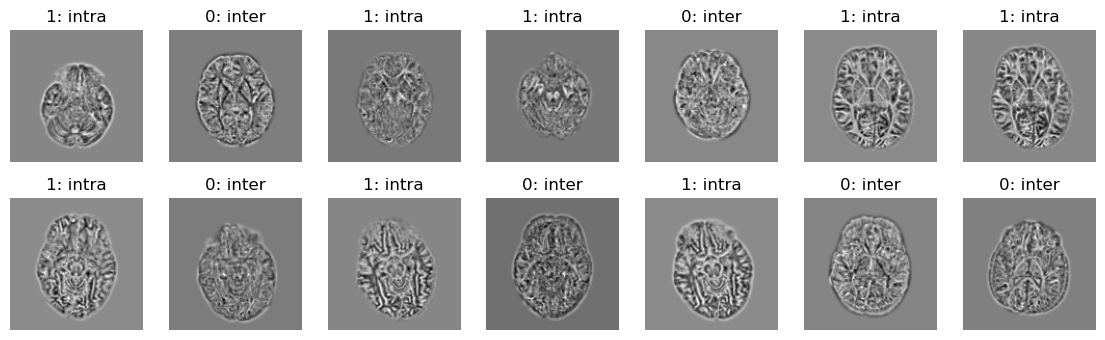

In [73]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 7, figsize=(14, 4))

for i in range(28, 42):
    row = (i-28) // 7
    col = (i-28) % 7
    image = x_train[i, :, :, :]
    label = y_train[i]
    axes[row, col].imshow(np.squeeze(image[:, :, 32]), cmap='gray')
    if label == 1:
        axes[row, col].set_title("1: intra")
    elif label == 0:
        axes[row, col].set_title("0: inter")
    axes[row, col].axis('off')

plt.show()


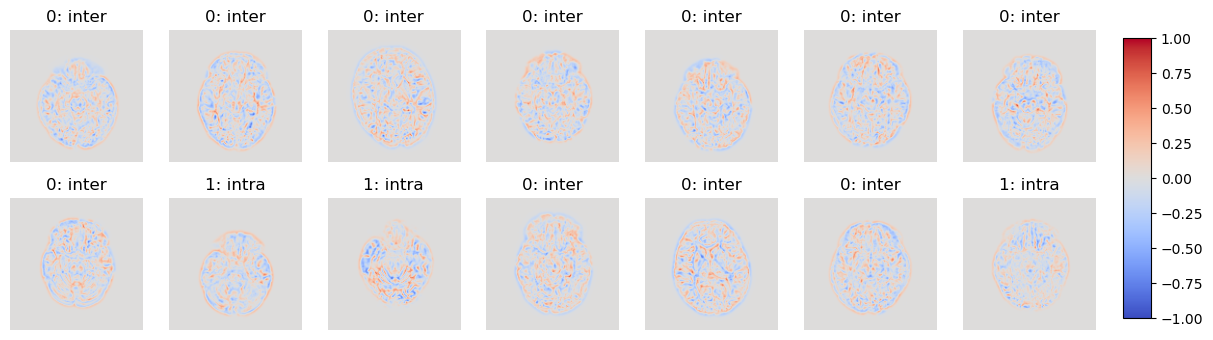

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a colorbar to go from -1 to 1
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, axes = plt.subplots(2, 7, figsize=(14, 4))

for i in range(14):
    row = i // 7
    col = i % 7
    image = x_train[i, :, :, :]
    label = y_train[i]
    axes[row, col].imshow(np.squeeze(image[:, :, 32]), cmap='coolwarm', norm=norm)
    if label == 1:
        axes[row, col].set_title("1: intra")
    elif label == 0:
        axes[row, col].set_title("0: inter")
    axes[row, col].axis('off')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)

plt.show()


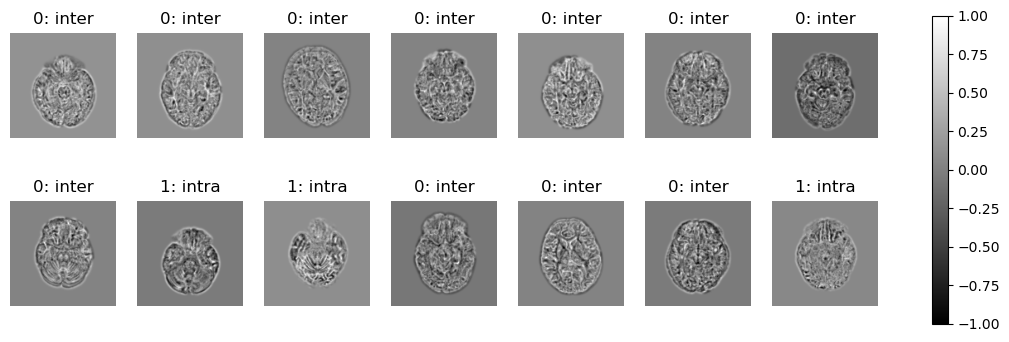

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Create a custom colormap for the grayscale background
cmap = plt.cm.get_cmap('gray')

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(-1, 1)

fig, axes = plt.subplots(2, 7, figsize=(14, 4))

for i in range(14):
    row = i // 7
    col = i % 7
    image = x_train[i, :, :, :]
    label = y_train[i]
    
    im = axes[row, col].imshow(np.squeeze(image[:, :, 32]), cmap=cmap)
    
    if label == 1:
        axes[row, col].set_title("1: intra")
    elif label == 0:
        axes[row, col].set_title("0: inter")
    
    axes[row, col].axis('off')

# Add colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
# cbar.set_label('Values from -1 to 1')

plt.show()


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already scaled as values from -1 to 1.

In [76]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the data on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

2023-10-31 23:00:12.982119: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-31 23:00:12.991537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 23:00:12.991791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-10-31 23:00:12.993523: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-10-31 23:00:13.011998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-31 23:00:13.022066: I tensorflow/stream_executor/pla

Visualize an augmented CT scan.

2023-10-31 23:00:18.636045: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 859832320 exceeds 10% of free system memory.


Dimension of the MRI scan is: (128, 128, 64, 1)


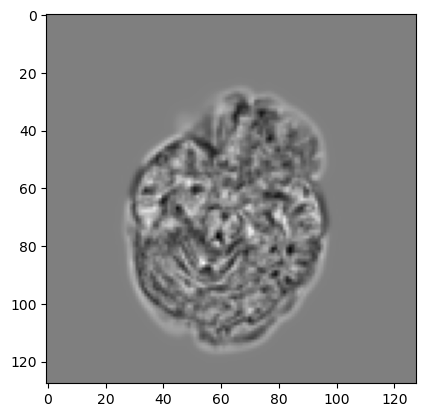

In [77]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


In [79]:
image.shape

(128, 128, 64, 1)

Since a CT scan has many slices, let's visualize a montage of the slices.

In [80]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 40 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40, :])

TypeError: 'int' object is not callable

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [81]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Train model

In [82]:
class CustomModelCheckpoint(keras.callbacks.ModelCheckpoint):
    def __init__(self, train_dir, **kwargs):
        self.train_dir = train_dir
        filepath = f"{self.train_dir}/3d_image_classification_epoch{{epoch:02d}}.h5"
        super().__init__(filepath=filepath, **kwargs)

In [83]:
# Train iteration number to be changed based on the experiment
train_iteration = '_no_overlap_1'
# Define train_dir and log_dir
train_dir = os.path.join(os.getcwd(), f'train{train_iteration}')
log_dir = os.path.join(train_dir, "logs")
# Create both train_dir and log_dir if not already existent
for directory in [train_dir, log_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = CustomModelCheckpoint(
    train_dir,
    save_best_only=True,
    monitor='val_loss',  # Set the metric to monitor, typically validation loss
    verbose=1,  # Set to 1 to receive a message when a new best model is saved
    mode='min'  # Set to 'min' if you are monitoring a metric like validation loss
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Add the TensorBoard callback to the list of callbacks
callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]  # Include other callbacks as well

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=callbacks,
)

2023-11-01 09:24:27.971707: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-11-01 09:24:27.972357: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 1 GPUs
2023-11-01 09:24:27.977272: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcupti.so.10.1
2023-11-01 09:24:28.077975: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-11-01 09:24:28.078424: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-11-01 09:24:28.078789: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, C

Epoch 1/100


2023-11-01 09:24:30.200128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-01 09:25:53.392594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-01 09:38:57.400347: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-01 09:39:11.030324: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-11-01 09:39:11.030390: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-11-01 09:39:11.030472: E te


Epoch 00001: val_loss improved from inf to 1.00119, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_no_overlap_0/3d_image_classification_epoch01.h5
103/103 - 32s - loss: 0.5332 - acc: 0.7122 - val_loss: 1.0012 - val_acc: 0.6818
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.00119
103/103 - 18s - loss: 0.4228 - acc: 0.8195 - val_loss: 2.1900 - val_acc: 0.6818
Epoch 3/100

Epoch 00003: val_loss did not improve from 1.00119
103/103 - 18s - loss: 0.3911 - acc: 0.8439 - val_loss: 2.5638 - val_acc: 0.6818
Epoch 4/100

Epoch 00004: val_loss did not improve from 1.00119
103/103 - 18s - loss: 0.3593 - acc: 0.8634 - val_loss: 1.5159 - val_acc: 0.6818
Epoch 5/100

Epoch 00005: val_loss improved from 1.00119 to 0.92153, saving model to /home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/train_no_overlap_0/3d_image_classification_epoch05.h5
103/103 - 18s - loss: 0.2988 - acc: 0.8683 - val_loss: 0.9215 - val_ac

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing the model

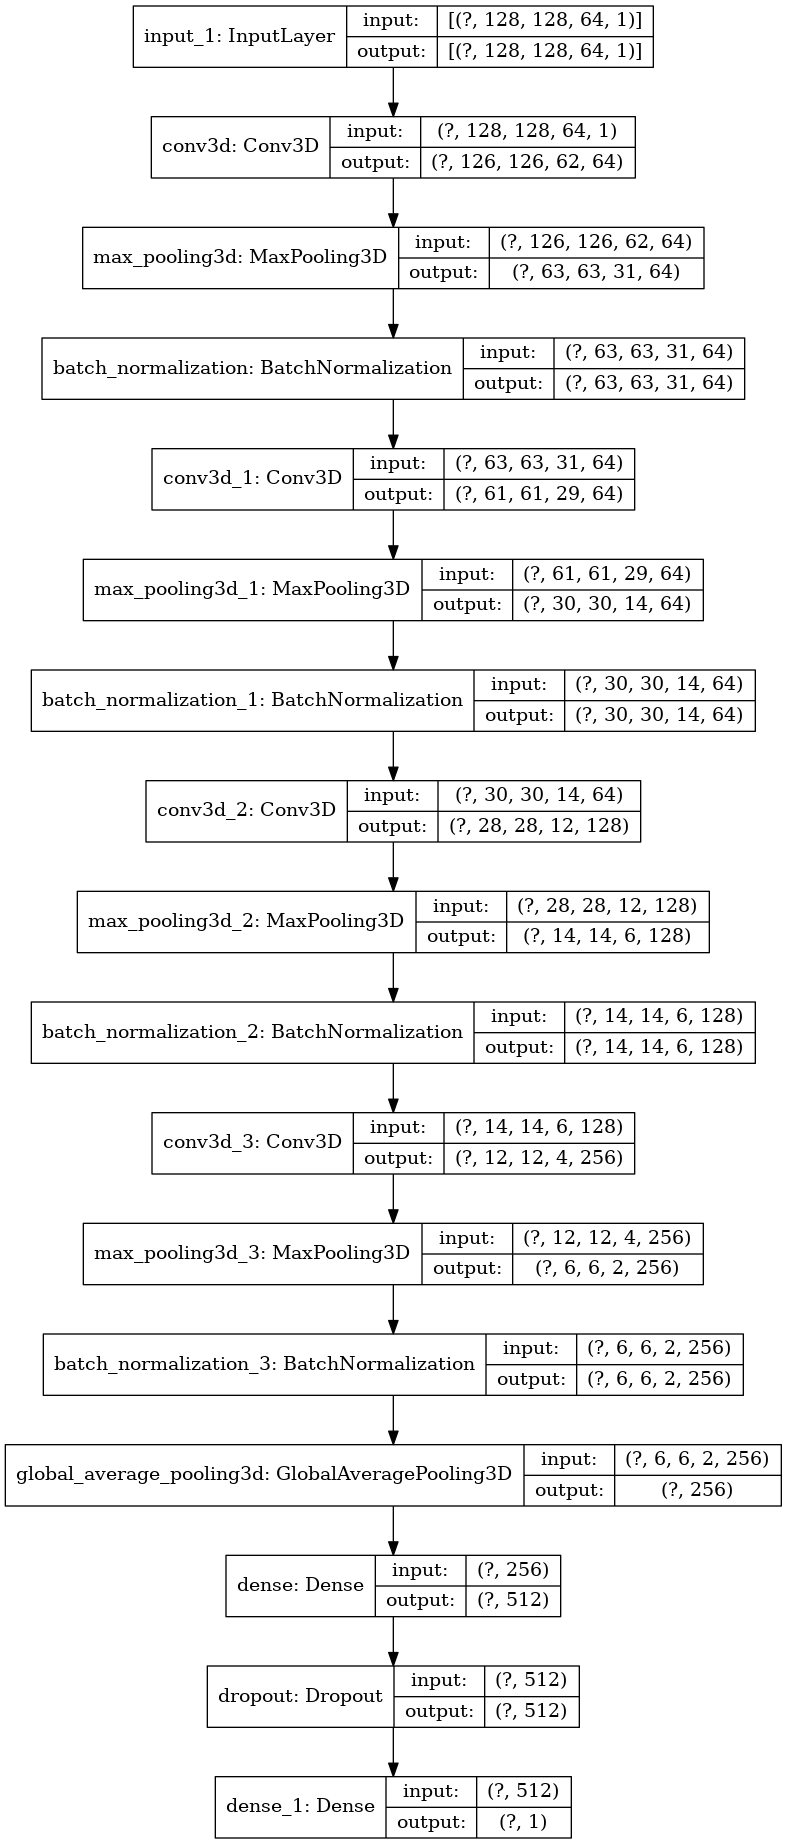

In [39]:
from tensorflow.keras.utils import plot_model
# Save the model architecture as an image file
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

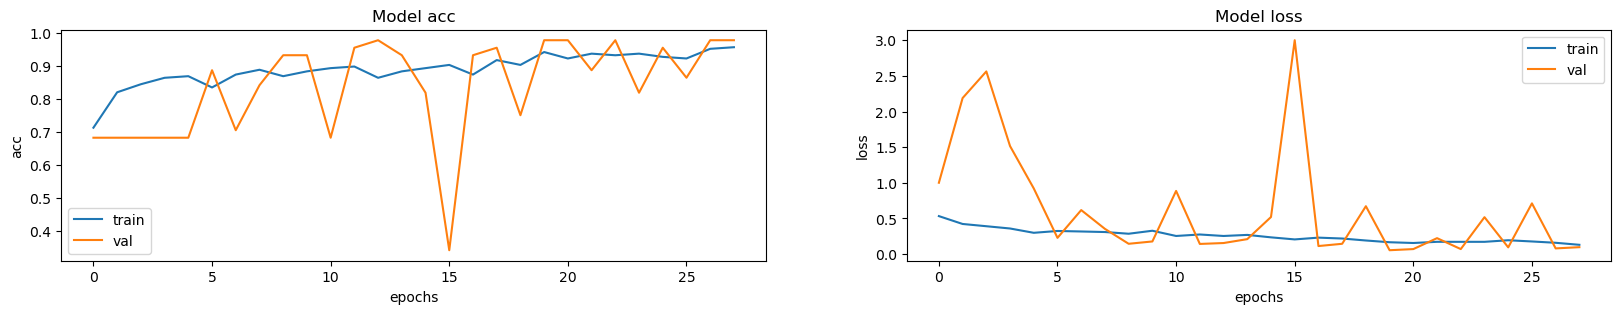

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single MRI scan

In [88]:
print('x_val shape', x_val.shape)
img_number = 40
img_to_predict = x_val[img_number]
# 1 is for intra and 0 is for inter
y_val_to_be_predicted = y_val[img_number]
epoch = '20'
model.load_weights(f"{train_dir}/3d_image_classification_epoch{epoch}.h5")
prediction = model.predict(np.expand_dims(img_to_predict, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["inter", "intra"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

x_val shape (44, 128, 128, 64)
This model is 93.65 percent confident that MRI scan is inter
This model is 6.35 percent confident that MRI scan is intra


## Calculate accuracy on validation set

In [89]:
class_names = ["inter", "intra"]
correct_predictions = 0

for sample_index in range(x_val.shape[0]):
    img_to_predict = x_val[sample_index].reshape(1, *x_val[sample_index].shape)
    true_class = y_val[sample_index]

    prediction = model.predict(img_to_predict)[0]
    predicted_class = 1 if prediction[0] >= 0.5 else 0  # Assuming a threshold of 0.5

    predicted_class_name = class_names[predicted_class]
    true_class_name = class_names[true_class]

    if predicted_class == true_class:
        # print(f"Sample {sample_index}: The model correctly predicted the MRI scan as {predicted_class_name}.")
        correct_predictions += 1
    else:
        print(f"Sample {sample_index}: The model predicted the MRI scan as {predicted_class_name}, but the true class is {true_class_name}.")

accuracy_percentage = (correct_predictions / x_val.shape[0]) * 100
print(f"Accuracy on validation set: {accuracy_percentage:.2f}% ({correct_predictions}/{x_val.shape[0]} samples were correct).")


Sample 33: The model predicted the MRI scan as inter, but the true class is intra.
Accuracy on validation set: 97.73% (43/44 samples were correct).


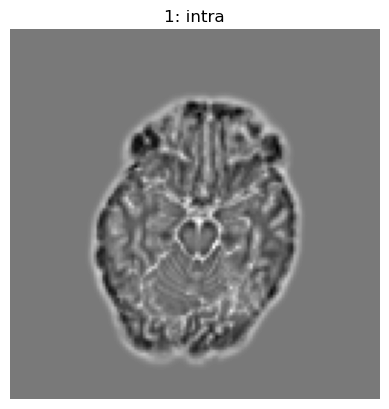

In [90]:
i = 33
image = x_val[i, :, :, :]
label = y_val[i]
plt.imshow(np.squeeze(image[:, :, 32]), cmap='gray')
if label == 1:
    plt.title("1: intra")
elif label == 0:
    plt.title("0: inter")
plt.axis('off')
plt.show()

## Calculate accuracy on test set

In [91]:
class_names = ["inter", "intra"]
correct_predictions = 0
y_pred = []

for sample_index in range(x_test.shape[0]):
    img_to_predict = x_test[sample_index].reshape(1, *x_test[sample_index].shape)
    true_class = y_test[sample_index]

    prediction = model.predict(img_to_predict)[0]
    
    predicted_class = 1 if prediction[0] >= 0.5 else 0  # Assuming a threshold of 0.5
    y_pred.append(predicted_class)

    predicted_class_name = class_names[predicted_class]
    true_class_name = class_names[true_class]

    if predicted_class == true_class:
        # print(f"Sample {sample_index}: The model correctly predicted the MRI scan as {predicted_class_name}.")
        correct_predictions += 1
    else:
        print(f"Sample {sample_index}: The model predicted the MRI scan as {predicted_class_name}, but the true class is {true_class_name}.")

accuracy_percentage = (correct_predictions / x_test.shape[0]) * 100
print(f"Accuracy on test set: {accuracy_percentage:.2f}% ({correct_predictions}/{x_test.shape[0]} samples were correct).")


Accuracy on test set: 100.00% (30/30 samples were correct).


In [93]:
from sklearn.metrics import accuracy_score, f1_score

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

accuracy 1.0
f1_score 1.0


### Calculate AUC (Area under curve) on test set

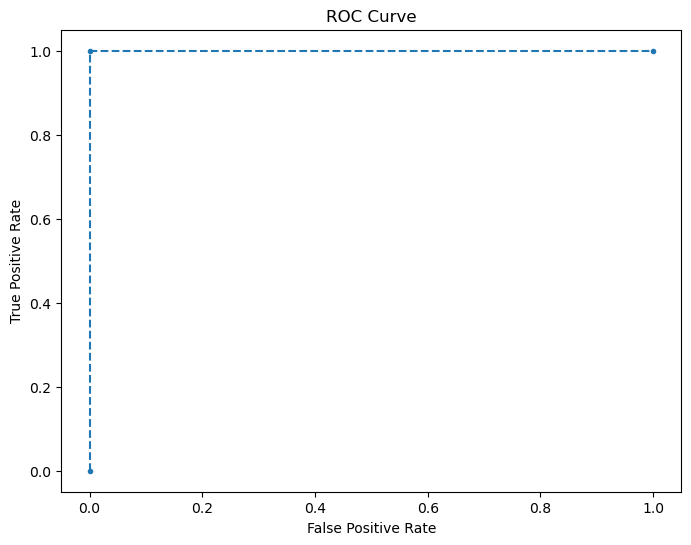

In [94]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# y_true contains the true binary labels (0 or 1)
# y_pred contains the predicted probabilities for the positive class
auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [95]:
y_pred_class = [class_names[item] for item in y_pred]
y_test_class = [class_names[item] for item in y_test]

tn: 24 fp: 0 fn: 0 tp: 6


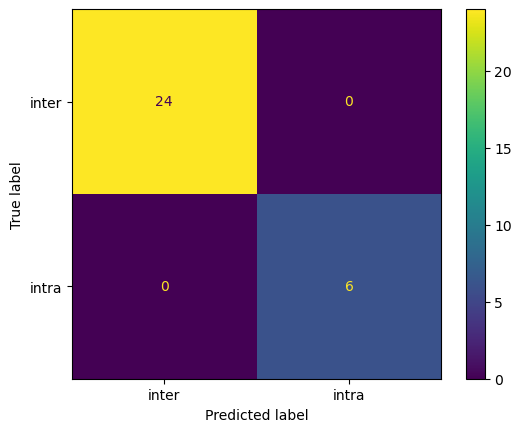

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['inter', 'intra'])

disp.plot()
plt.show()
